#Becca
##---------------------------

In [ ]:
import sys, os
cwd = os.getcwd()
sys.path[0] = cwd[:cwd.rfind('/')]

In [ ]:
import numpy as np
import pandas as pd
from google.cloud import bigquery

In [ ]:
#Google cloud credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='/content/Saltiest HN Trolls.json'

# Create a "Client" object
client = bigquery.Client()

# Bigquery dataset reference
hn_ref = client.dataset('hacker_news', project='hn-dataset')

In [ ]:
# Run SQL query to obtain filtered table
query_string = """
SELECT C.by
FROM (
  SELECT A.by, COUNT(*) AS count
  FROM `bigquery-public-data.hacker_news.full` AS A
  GROUP BY A.by
  ORDER BY count DESC
  LIMIT 100
) AS C
WHERE C.by != "None"
"""

frequent_users = client.query(query_string).result().to_dataframe()

In [ ]:
# This is a triple-nested query that gets a number of comments made only by the most
# frequent users.  Change the "LIMIT XXX" part of the inner-most query to tune the
# number of users.  Change the outermost "LIMIT YYY" to change the total number of comments.
query_string = """
SELECT *
FROM `bigquery-public-data.hacker_news.full` AS A
WHERE A.by IN (
  SELECT C.by
  FROM (
    SELECT A.by, COUNT(*) AS count
    FROM `bigquery-public-data.hacker_news.full` AS A
    GROUP BY A.by
    ORDER BY count DESC
    LIMIT 500
  ) AS C
  WHERE C.by != "None"
)
LIMIT 50000
"""

df = client.query(query_string).result().to_dataframe()

In [ ]:
df.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,"Like I said, to be honest I do not know if it ...",None,davidw,NaN,1222716762,2008-09-29 19:32:42+00:00,comment,318709,318705.0,NaN,None,None
1,Modern ClojureScript,https://github.com/magomimmo/modern-cljs,None,None,brudgers,83.0,1438621836,2015-08-03 17:10:36+00:00,story,9997830,NaN,11.0,None,None
2,None,None,"Well, because heat dissipation is proportional...",None,stcredzero,NaN,1340822020,2012-06-27 18:33:40+00:00,comment,4168406,4165347.0,NaN,None,None
3,None,None,"So?<p><a href=""https:&#x2F;&#x2F;streeteasy.co...",None,perl4ever,NaN,1570229208,2019-10-04 22:46:48+00:00,comment,21162521,21160429.0,NaN,None,None
4,None,None,"Yes, because beating someone for doing or thin...",None,TeMPOraL,NaN,1570531967,2019-10-08 10:52:47+00:00,comment,21190821,21190776.0,NaN,None,None


In [ ]:
df.shape

(50000, 14)

In [ ]:
df['by'].value_counts()

tptacek         711
jacquesm        542
dang            530
dragonwriter    497
rbanffy         457
               ... 
matwood          43
hhs              42
sjg007           41
laumars          41
sametmax         39
Name: by, Length: 499, dtype: int64

In [ ]:
df['type'].value_counts()

comment    44622
story       5351
pollopt       26
poll           1
Name: type, dtype: int64

In [ ]:
# filter out by type (keep story and comment)
df[(df['type'] == 'story') | (df['type'] == 'comment')]

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,"Like I said, to be honest I do not know if it ...",None,davidw,NaN,1222716762,2008-09-29 19:32:42+00:00,comment,318709,318705.0,NaN,None,None
1,Modern ClojureScript,https://github.com/magomimmo/modern-cljs,None,None,brudgers,83.0,1438621836,2015-08-03 17:10:36+00:00,story,9997830,NaN,11.0,None,None
2,None,None,"Well, because heat dissipation is proportional...",None,stcredzero,NaN,1340822020,2012-06-27 18:33:40+00:00,comment,4168406,4165347.0,NaN,None,None
3,None,None,"So?<p><a href=""https:&#x2F;&#x2F;streeteasy.co...",None,perl4ever,NaN,1570229208,2019-10-04 22:46:48+00:00,comment,21162521,21160429.0,NaN,None,None
4,None,None,"Yes, because beating someone for doing or thin...",None,TeMPOraL,NaN,1570531967,2019-10-08 10:52:47+00:00,comment,21190821,21190776.0,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,None,None,I believe that you hold your views in good fai...,None,dang,NaN,1565715946,2019-08-13 17:05:46+00:00,comment,20687789,20685847.0,NaN,None,None
49996,None,None,Another vote for Fastmail!,None,toomuchtodo,NaN,1580831136,2020-02-04 15:45:36+00:00,comment,22236828,22236621.0,NaN,None,None
49997,None,None,You can get a pretty decent number for the car...,None,ars,NaN,1568924058,2019-09-19 20:14:18+00:00,comment,21020254,21018030.0,NaN,None,None
49998,NASA wants more humans to walk on the moon – a...,https://www.usatoday.com/story/tech/nation-now...,None,None,evo_9,1.0,1532008721,2018-07-19 13:58:41+00:00,story,17566297,NaN,1.0,None,None


In [ ]:
# drop some columns
#drop title, has 447,218 null values 
#drop ranking, has 500000 null values
#drop score, has 446968 null values 
clean_df = df.drop(['time', 'descendants', 'deleted', 'url', 'dead', 'title', 'ranking', 'score'], axis=1)

In [ ]:
# average of all texts
clean_df['text'].str.len().mean()

425.17194560014315

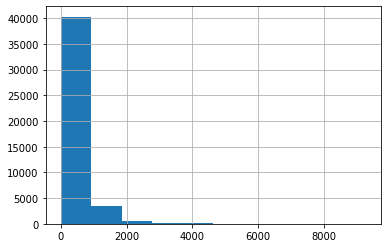

In [ ]:
# histogram of all text lengths
clean_df['text'].str.len().hist()

In [ ]:
# description of story texts
clean_df[clean_df['type'] == 'story']['text'].str.len().describe()

count      58.000000
mean      743.172414
std       927.866675
min        82.000000
25%       243.000000
50%       455.000000
75%       936.000000
max      5744.000000
Name: text, dtype: float64

In [ ]:
# description of comment texts
clean_df[clean_df['type'] == 'comment']['text'].str.len().describe()

count    44621.000000
mean       425.001165
std        490.450112
min          2.000000
25%        144.000000
50%        276.000000
75%        528.000000
max       9262.000000
Name: text, dtype: float64

In [ ]:
aux = clean_df[clean_df['type'] == 'comment']
aux2 = aux[aux['text'].str.len() <= 5]
aux2.head(10)

,text,by,timestamp,type,id,parent
290,Why?,pjc50,2018-09-03 11:00:32+00:00,comment,17901808,17901803.0
2868,Sure.,WalterBright,2020-03-26 19:18:06+00:00,comment,22696891,22696659.0
5497,Why?,fiatjaf,2015-03-16 13:26:51+00:00,comment,9211244,9209702.0
5571,120,paulddraper,2016-04-25 20:01:08+00:00,comment,11566884,11566290.0
6391,Chess,ThomPete,2010-06-06 20:52:25+00:00,comment,1409139,1409136.0
8142,Why?,tptacek,2008-03-16 23:08:38+00:00,comment,138497,138478.0
10156,No.,onion2k,2018-10-15 12:11:31+00:00,comment,18219037,18218878.0
12149,Yes.,Tomte,2015-08-07 13:04:37+00:00,comment,10022183,10022155.0
13139,No.,sjg007,2020-03-31 13:15:33+00:00,comment,22737162,22737153.0
13188,Yeah.,coldtea,2015-05-02 22:42:58+00:00,comment,9478845,9477854.0


In [ ]:
aux2.shape

(42, 6)

In [ ]:
aux2['text'].nunique()

25

In [ ]:
#only 507 comments with 5 characters or less, upon analysis doesn't look like they provide much context, 
#not helpful for model analysis so drop comments with 5 words or less

# take only the rows whose text column's length is greater than five
# this also removes the texts that are None
clean_df = clean_df[clean_df['text'].str.len() > 5]

In [ ]:
clean_df.head()

,text,by,timestamp,type,id,parent
0,"Like I said, to be honest I do not know if it ...",davidw,2008-09-29 19:32:42+00:00,comment,318709,318705.0
2,"Well, because heat dissipation is proportional...",stcredzero,2012-06-27 18:33:40+00:00,comment,4168406,4165347.0
3,"So?<p><a href=""https:&#x2F;&#x2F;streeteasy.co...",perl4ever,2019-10-04 22:46:48+00:00,comment,21162521,21160429.0
4,"Yes, because beating someone for doing or thin...",TeMPOraL,2019-10-08 10:52:47+00:00,comment,21190821,21190776.0
5,I think downvotes are fundamentally broken.<p>...,Someone1234,2019-08-06 21:13:12+00:00,comment,20629696,20628433.0


In [ ]:
clean_df['text'].str.len().describe()

count    44658.000000
mean       425.624905
std        491.404972
min          6.000000
25%        144.000000
50%        276.000000
75%        528.000000
max       9262.000000
Name: text, dtype: float64

In [ ]:
# Use BS on a single piece of text to remove strange chars and URLs and tags
from bs4 import BeautifulSoup

def clean_soup(text):
    # make a soup - this takes care of strange characters
    soup = BeautifulSoup(text, "html.parser")

    # delete <a> tags as they contain URLs -- remember <a href="url_here">
    # tags contain URLs
    for s in soup.select('a'):
       s.extract()

    # the soup contains <p> tags -- here we get rid of those and join them with spaces
    strings = soup.find_all(text=True, recursive=True)
    result = ' '.join(strings)

    return result

In [ ]:
# Apply that to each comment/story text
clean_text = clean_df['text'].apply(clean_soup)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https:&#x2F;&#x2F;www.pcisecuritystandards.org&#x2F;documents&#x2F;SAQ_A-EP_v3.pdf" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [ ]:
clean_df['text'] = clean_text

In [ ]:
import pandas as pd
pd.options.display.max_colwidth = 100
clean_df.sample(10)

,text,by,timestamp,type,id,parent
1385,"""Well, turns out I'm not ""the next Bill Gates"". But I sure have spent the last 10 years trying t...",mgkimsal,2014-03-17 15:59:03+00:00,comment,7415860,7415673.0
8146,"> In every single case where you might want a repeated oneof, you always want to wrap it in a me...",Dylan16807,2018-10-11 12:11:49+00:00,comment,18192797,18190005.0
10389,"Maybe replace the Wii, but it's going to need a lot more power and dedication to game playing pe...",chrischen,2010-09-03 01:22:29+00:00,comment,1658294,1658269.0
38321,A little bit of friendly whimsy has actually proven to be a fantastic business attribute. Think ...,pbreit,2014-12-06 05:14:53+00:00,comment,8708428,8703063.0
20154,> more than a third That would be pretty trivial at the current state. Maybe that why they acted...,gcb0,2013-08-06 03:35:59+00:00,comment,6164656,6163848.0
47069,"The discussion months ago was about x86, I believe. According to the article, ""For non-ARM syste...",tzs,2012-01-13 03:35:51+00:00,comment,3459066,3458889.0
6784,There is a very real possibility that the wing was pulled by a cable. The kite adapted is actual...,angersock,2012-03-21 15:52:34+00:00,comment,3734916,3734774.0
28258,There are a whole bunch of recent US geopolitical actions that are interesting to look at throug...,maxerickson,2015-07-28 15:37:52+00:00,comment,9962303,9961928.0
5779,"When you choose a weather location manually, you actually get a less fine-grained report than th...",derefr,2020-01-13 23:26:22+00:00,comment,22039934,22039832.0
18292,That's pretty subtle. In comparison BMWs used to have a bug in their nav unit that resulted in n...,huhtenberg,2015-01-12 12:48:49+00:00,comment,8873585,8873416.0


In [ ]:
#makes sense the parent would have some null values, if they are the first comment
clean_df.isnull().sum()

text          0
by            0
timestamp     0
type          0
id            0
parent       79
dtype: int64

#Pyrom
##---------------------------

In [ ]:
pip install vaderSentiment

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Panda Settings
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [ ]:
clean_df.head()

,text,by,timestamp,type,id,parent
0,"Like I said, to be honest I do not know if it is in any way an accurate analogy, but it seems ...",davidw,2008-09-29 19:32:42+00:00,comment,318709,318705.0
2,"Well, because heat dissipation is proportional to the square of the voltage, you end up giving u...",stcredzero,2012-06-27 18:33:40+00:00,comment,4168406,4165347.0
3,So?,perl4ever,2019-10-04 22:46:48+00:00,comment,21162521,21160429.0
4,"Yes, because beating someone for doing or thinking something is a proven way of making them stop...",TeMPOraL,2019-10-08 10:52:47+00:00,comment,21190821,21190776.0
5,I think downvotes are fundamentally broken. If upvotes are agree/approval and downvotes are disa...,Someone1234,2019-08-06 21:13:12+00:00,comment,20629696,20628433.0


In [ ]:
df = clean_df.drop(columns=['timestamp', 'type', 'id', 'parent'])
df.head()

,text,by
0,"Like I said, to be honest I do not know if it is in any way an accurate analogy, but it seems ...",davidw
2,"Well, because heat dissipation is proportional to the square of the voltage, you end up giving u...",stcredzero
3,So?,perl4ever
4,"Yes, because beating someone for doing or thinking something is a proven way of making them stop...",TeMPOraL
5,I think downvotes are fundamentally broken. If upvotes are agree/approval and downvotes are disa...,Someone1234


In [ ]:
#Convert to string values
df = df.astype(str)

In [ ]:
#No. of rows
df.shape

(44658, 2)

In [ ]:
#Slim out users with less than 1000 comments, more manageable, cuts data in half
def slim(df):
    """
    Slim out dataset to user with 1000 or more comments.

    Returns a filtered dataframe.
    """

    X = df.copy()
    X = X.groupby('by').filter(lambda x: x['by'].count()<1000)

    return X

In [ ]:
new_df = slim(df)
print(new_df.shape)
new_df.head()

(44658, 2)


,text,by
0,"Like I said, to be honest I do not know if it is in any way an accurate analogy, but it seems ...",davidw
2,"Well, because heat dissipation is proportional to the square of the voltage, you end up giving u...",stcredzero
3,So?,perl4ever
4,"Yes, because beating someone for doing or thinking something is a proven way of making them stop...",TeMPOraL
5,I think downvotes are fundamentally broken. If upvotes are agree/approval and downvotes are disa...,Someone1234


In [ ]:
#No. of usernames
new_df['by'].value_counts().sum()

44658

In [ ]:
new_df.isnull().sum()

text    0
by      0
dtype: int64

In [ ]:
#Machine Learning, using VADER Sentiment Analysis

def sentiment_score(comment):
    analyser = SentimentIntensityAnalyzer()
    
    x = 0
    score = analyser.polarity_scores(comment)
    x = x + score['pos']
    x = x + score['compound']
    x = x - score['neg'] 

    return x

In [ ]:
#Apply function to 'text' column, values added to new column called Saltiness
new_df['Saltiness'] = new_df['text'].apply(sentiment_score)

In [ ]:
new_df.head()

,text,by,Saltiness
0,"Like I said, to be honest I do not know if it is in any way an accurate analogy, but it seems ...",davidw,-0.6304
2,"Well, because heat dissipation is proportional to the square of the voltage, you end up giving u...",stcredzero,1.0085
3,So?,perl4ever,0.0000
4,"Yes, because beating someone for doing or thinking something is a proven way of making them stop...",TeMPOraL,-0.8053
5,I think downvotes are fundamentally broken. If upvotes are agree/approval and downvotes are disa...,Someone1234,0.2368


In [ ]:
#Rename columns
new_df.columns = ['Comment', 'Username', 'Saltiness']

In [ ]:
#Rearrange columns, sort by username
order = ['Username', 'Comment', 'Saltiness']
users_score = new_df[order]

In [ ]:
#Sort
users_score.sort_values(by=['Username'], inplace=True)

In [ ]:
#Created copy just in case df needed to be reset
#import copy

#reset_df = copy.copy(new_df)

In [ ]:
#reset_df.head()

In [ ]:
#users_score = copy.copy(reset_df)

In [ ]:
#Drop comment column, and groupby username
users_score.drop(columns=['Comment'], inplace=True)
users_score.head()

,Username,Saltiness
15981,001sky,-0.7535
39939,001sky,0.3831
331,001sky,-0.3710
9403,001sky,-0.1810
35763,001sky,0.9129


In [ ]:
users_score = users_score.groupby('Username', as_index=False)['Saltiness'].mean()

In [ ]:
users_score.head(10)

,Username,Saltiness
0,001sky,0.059852
1,Alex3917,0.087417
2,AndrewKemendo,0.388931
3,AnimalMuppet,0.192187
4,Animats,0.071777
5,Anon84,0.380692
6,AnthonyMouse,0.027867
7,Apocryphon,0.332398
8,AstralStorm,0.140393
9,BurningFrog,0.106077


In [ ]:
#Convert Saltiness column to percent
users_score['Saltiness']=users_score['Saltiness'].apply('{:.0%}'.format)

In [ ]:
users_score.head(40)

,Username,Saltiness
0,001sky,6%
1,Alex3917,9%
2,AndrewKemendo,39%
3,AnimalMuppet,19%
4,Animats,7%
5,Anon84,38%
6,AnthonyMouse,3%
7,Apocryphon,33%
8,AstralStorm,14%
9,BurningFrog,11%
